In [7]:

import numpy as np
import tensorflow as tf
import time
import os
import h5py
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.ndimage import binary_erosion
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prepare_data.h5functions import save_to_h5
from utils.evaluate_utils import *
import pyvista as pv
plt.rcParams['figure.figsize'] = [10, 8]
from scipy.signal import convolve2d, convolve

In [26]:
# load 
in_vivo_path = '../data/PIA/THORAX/P02/h5/P02.h5'
in_vivo_path_LV = '../data/PIA/THORAX/P02/h5/P02_LV.h5'
in_silico_path = '../data/CARDIAC/M2_2mm_step2_static_dynamic.h5'

name_in_vivo = os.path.basename(in_vivo_path)[:-2]
name_in_silico = os.path.basename(in_silico_path)[:2]
in_vivo = {}
in_silico = {}
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']
vencs = {}

with h5py.File(in_vivo_path, mode = 'r' ) as p1:
    with h5py.File(in_silico_path, mode = 'r' ) as p2:
        with h5py.File(in_vivo_path_LV, mode = 'r' ) as p3:
            print(p1.keys(), p2.keys())
            # load mask and distriguish between complete and left ventricle (LV) mask 
            in_vivo['mask'] =  np.asarray(p1['mask']).squeeze()
            in_vivo['mask_LV'] = np.asarray(p3['mask']).squeeze()
            in_silico['mask'] = np.asarray(p2['mask']).squeeze()

            for mag,vel, venc in zip(mag_colnames,vel_colnames, venc_colnames):
                in_vivo[mag]   = np.asarray(p1[mag])
                in_silico[mag] = np.asarray(p2[mag])

                in_vivo[vel]   = np.asarray(p1[vel])
                in_silico[vel] = np.asarray(p2[vel])

                in_vivo[f'{vel}_fluid']   = np.multiply(in_vivo[vel], in_vivo['mask'])
                in_silico[f'{vel}_fluid'] = np.multiply(in_silico[vel], in_silico['mask'])
            
            in_vivo['bounds_LV'], _ = get_boundaries(in_vivo['mask_LV']) # carful here we take only the boundary of left ventricle mask
            in_vivo['bounds'], _ = get_boundaries(in_vivo['mask'])
            in_silico['bounds'], _ = get_boundaries(in_silico['mask'])

            


<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']> <KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>


In [9]:
#help functions

def spatial3D_NN_interpolation(lr, hr_shape, method = 'nearest'):

    x_lr = np.arange(0, lr.shape[0])
    y_lr = np.arange(0, lr.shape[1])
    z_lr = np.arange(0, lr.shape[2])

    x_hr = np.linspace(0, lr.shape[0],  int(hr_shape[0]))
    y_hr = np.linspace(0, lr.shape[1],  int(hr_shape[1]))
    z_hr = np.linspace(0, lr.shape[2],  int(hr_shape[2]))
    
    xg, yg ,zg = np.meshgrid(x_hr, y_hr, z_hr, indexing='ij', sparse=True)

    interp = RegularGridInterpolator((x_lr, y_lr, z_lr), lr, method=method, bounds_error=False, fill_value=0)
    interpolate = interp((xg, yg ,zg))
    return interpolate


### Transformation
 1. Set large enough coordinate system
 2. Find LV, mark it and find center point of gravity in there
 3. Compare number of voxels. If necessary scale in vivo by using imterpolation (NN, linear ..)
 3. Insert in vivo mask such that the midpoints overlap , i.e. [mid_c -patch_size_x]
 4. r

In [18]:
# load an look at data
frame = 10

# load complete mask
mask_v =  in_vivo['mask'][frame]
mask_s =  in_silico['mask'][frame]

#load boundary
bounds_v = in_vivo['bounds_LV'][frame]
bounds_s = in_silico['bounds'][frame]

# load/get left vetricle mask
mask_LV_s =  mask_s.copy()
mask_LV_s[50:, :, :] = 0 #This needs to be adapted for every part
mask_LV_s[:, :, :40] = 0
mask_LV_v = in_vivo['mask_LV'][frame]

print(mask_LV_s.shape, mask_v.shape, mask_LV_v.shape)

(84, 60, 96) (48, 108, 160) (48, 108, 160)


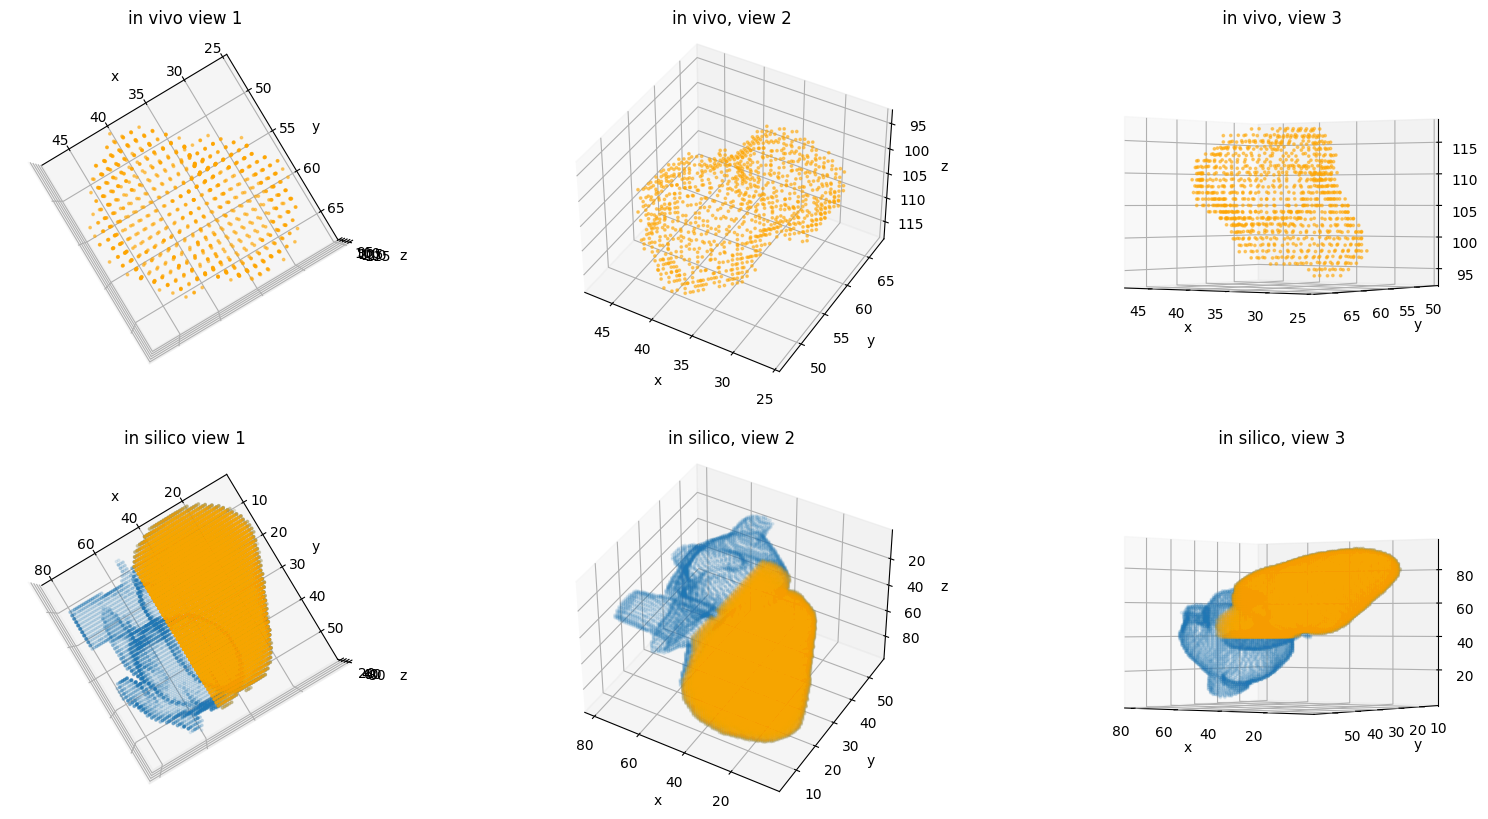

In [19]:
# Show the data stes which should be mapped
#--------------------Plot 3D angles----------------------

fig = plt.figure(figsize=(20,10))
#--------------plot 1------------------
ax = fig.add_subplot(2, 3, 1, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_v  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.5, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in vivo view 1')
ax.view_init(-270, 60)

#--------------plot 2------------------
ax = fig.add_subplot(2, 3, 2, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_v  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.5, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in vivo, view 2')
ax.view_init(-140, 60)

#--------------plot 3------------------
ax = fig.add_subplot(2, 3, 3, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_v  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.5, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f' in vivo, view 3')
ax.view_init(0, 125)

#-----------------in silico-------------------------------------
#--------------plot 4------------------
ax = fig.add_subplot(2, 3, 4, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_s  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in silico view 1')
ax.view_init(-270, 60)

#--------------plot 5------------------
ax = fig.add_subplot(2, 3, 5, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_s  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in silico, view 2')
ax.view_init(-140, 60)

#--------------plot 6------------------
ax = fig.add_subplot(2, 3, 6, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_s  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f' in silico, view 3')
ax.view_init(0, 125)

plt.show()


In [20]:
#--------------transformation--------------
print('No. points in mask: invivo /insilico LV', np.count_nonzero(mask_LV_v), '/', np.count_nonzero(mask_LV_s))
# Plotting
# find central point in LV 

def indivial_transformation_scale_rotate(data, scale, interpolation = 'NN'):
    #1. scaling
    # nearest neighbor interpolation
    if interpolation =='NN':
        data_transformed = spatial3D_NN_interpolation(data, (mask_LV_v.shape[0]*scale[0], mask_LV_v.shape[1]*scale[1], mask_LV_v.shape[2]*scale[2]))
    else:
        data_transformed = spatial3D_NN_interpolation(data, (mask_LV_v.shape[0]*scale[0], mask_LV_v.shape[1]*scale[1], mask_LV_v.shape[2]*scale[2]), method = 'linear')
    
    #2. rotation
    idx_rotation = np.index_exp[::-1, ::1, ::1]
    data_transformed = data_transformed[idx_rotation]
    
    return data_transformed

#transform the invivo data
mask_v_transformed = indivial_transformation_scale_rotate(mask_LV_v, [2, 2, 2])
bounds_v_transformed = indivial_transformation_scale_rotate(bounds_v, [2, 2, 2])

print('No. points in mask transformed: invivo /insilico', np.count_nonzero(mask_v_transformed), '/', np.count_nonzero(mask_LV_s))



No. points in mask: invivo /insilico LV 3111 / 56095
No. points in mask transformed: invivo /insilico 24868 / 56095


In [30]:

x_coord_v, y_coord_v, z_coord_v = np.where(mask_v_transformed>0)
x_coord_LV_s, y_coord_LV_s, z_coord_LV_s = np.where(mask_LV_s>0)

#find center of gravity in invivo and insilico w.r.t left ventricle
x_LV_v,y_LV_v, z_LV_v  = int(np.sum(x_coord_v)/np.sum(mask_v_transformed)), int(np.sum(y_coord_v)/np.sum(mask_v_transformed)), int(np.sum(z_coord_v)/np.sum(mask_v_transformed))
x_LV_s, y_LV_s, z_LV_s = int(np.sum(x_coord_LV_s)/np.sum(mask_LV_s)),  int(np.sum(y_coord_LV_s)/np.sum(mask_LV_s)), int(np.sum(z_coord_LV_s)/np.sum(mask_LV_s))

print('center of insilico LV ', x_LV_s, y_LV_s, z_LV_s)
print('center of invivo LV', x_LV_v, y_LV_v, z_LV_v)
# translation_vec = np.array([x_c, y_c, z_c]) - np.array([x_LV_c, y_LV_c, z_LV_c])

X_v, Y_v, Z_v = mask_v_transformed.shape
X_s, Y_s, Z_s = mask_s.shape

# make copy of  
combined_LV_mask = np.array(mask_s.copy(), dtype=np.uint8)

#indices for 3 dim data (spatial)
idx_insilico = np.index_exp[int(np.maximum(0, x_LV_s - x_LV_v )):int(np.minimum(x_LV_s +X_v- x_LV_v-1, X_s -1)), 
                            int(np.maximum(0, y_LV_s - y_LV_v )):int(np.minimum(y_LV_s +Y_v- y_LV_v-1, Y_s -1)), 
                            int(np.maximum(0, z_LV_s - z_LV_v )):int(np.minimum(z_LV_s +Z_v- z_LV_v-1, Z_s -1))]
idx_invivo =   np.index_exp[int(np.maximum(0, -(x_LV_s-x_LV_v))):int(np.minimum(X_v-1, x_LV_v+ X_s- x_LV_s-1)), 
                            int(np.maximum(0, -(y_LV_s-y_LV_v))):int(np.minimum(Y_v-1, y_LV_v+ Y_s- y_LV_s-1)), 
                            int(np.maximum(0, -(z_LV_s-z_LV_v))):int(np.minimum(Z_v-1, z_LV_v+ Z_s- z_LV_s-1))]

# indices for 4D data
idx_t_insilico = np.index_exp[:, int(np.maximum(0, x_LV_s - x_LV_v )):int(np.minimum(x_LV_s +X_v- x_LV_v-1, X_s -1)), 
                            int(np.maximum(0, y_LV_s - y_LV_v )):int(np.minimum(y_LV_s +Y_v- y_LV_v-1, Y_s -1)), 
                            int(np.maximum(0, z_LV_s - z_LV_v )):int(np.minimum(z_LV_s +Z_v- z_LV_v-1, Z_s -1))]
idx_t_invivo =   np.index_exp[:, int(np.maximum(0, -(x_LV_s-x_LV_v))):int(np.minimum(X_v-1, x_LV_v+ X_s- x_LV_s-1)), 
                            int(np.maximum(0, -(y_LV_s-y_LV_v))):int(np.minimum(Y_v-1, y_LV_v+ Y_s- y_LV_s-1)), 
                            int(np.maximum(0, -(z_LV_s-z_LV_v))):int(np.minimum(Z_v-1, z_LV_v+ Z_s- z_LV_s-1))]


#insert invivo into insilico
combined_LV_mask[idx_insilico] += np.asarray(mask_v_transformed[idx_invivo]*2, np.uint8)
print(np.unique(combined_LV_mask), np.unique(mask_v_transformed[idx_invivo]*2))

#-----------combine mask including aorta of invivo data with boundary of mask---------
# combine the boundary masks for visualization
combined_boundary_mask = np.array(bounds_s.copy(), dtype=np.uint8)
bounds_v_all_transformed = indivial_transformation_scale_rotate(in_vivo['bounds'][frame], [2, 2, 2])

combined_boundary_mask[idx_insilico] += np.asarray(bounds_v_all_transformed[idx_invivo]*2, np.uint8)

print("Shape of invivo transformed in scale and rotated", mask_v_transformed.shape, 'combined shape, ie. insilico' ,combined_LV_mask.shape)

center of insilico LV  31 27 65
center of invivo LV 22 114 213
[0 1 2 3] [0. 2.]
Shape of invivo transformed in scale and rotated (96, 216, 320) combined shape, ie. insilico (84, 60, 96)


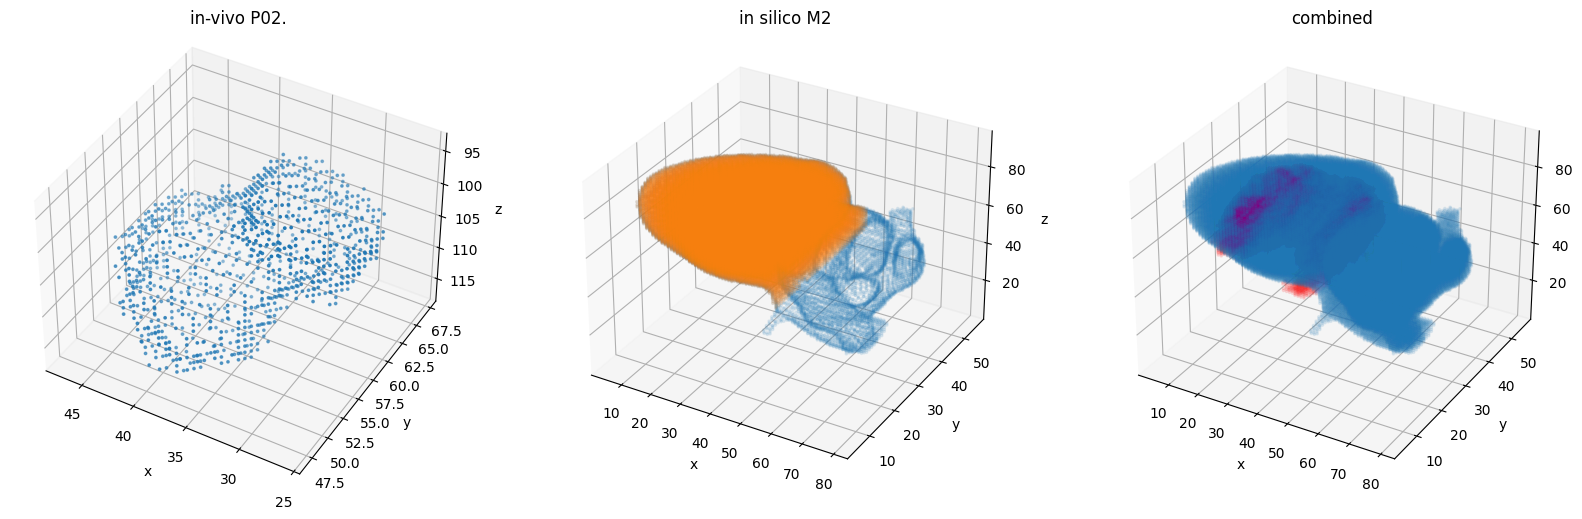

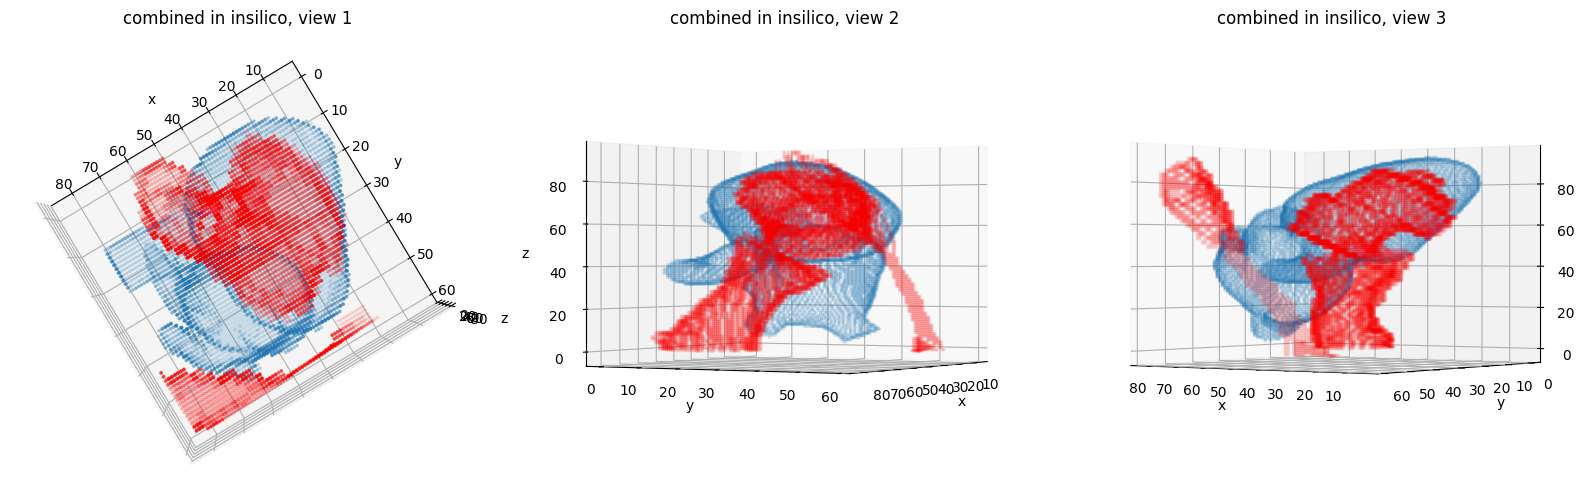

In [31]:
#---------Plot results-----------------


fig = plt.figure(figsize=(20,10))
#--------------plot 1------------------
ax = fig.add_subplot(1, 3, 1, projection='3d')
x_v, y_v, z_v = np.where(bounds_v ==1)
ax.scatter3D(x_v, y_v, z_v, s= 3) 

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in-vivo {name_in_vivo}')
ax.view_init(-140, 60)


#--------------plot 2------------------
ax = fig.add_subplot(1, 3, 2, projection='3d')
x_s, y_s, z_s = np.where(bounds_s ==1)
ax.scatter3D(x_s, y_s, z_s, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1) 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in silico {name_in_silico}')


#--------------plot 3------------------
ax = fig.add_subplot(1, 3, 3, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_LV_mask  ==1)
x_sv2, y_sv2, z_sv2 = np.where(combined_LV_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_LV_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined')
plt.show()

#--------------------Plot 3D angles----------------------

fig = plt.figure(figsize=(20,10))
#--------------plot 1------------------
ax = fig.add_subplot(1, 3, 1, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_boundary_mask  ==1)
x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined in insilico, view 1')
ax.view_init(-270, 60)

#--------------plot 2------------------
ax = fig.add_subplot(1, 3, 2, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_boundary_mask  ==1)
x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined in insilico, view 2')
ax.view_init(0, 30)
# ax.view_init(-140, 60)

#--------------plot 3------------------
ax = fig.add_subplot(1, 3, 3, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_boundary_mask  == 1)
x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined in insilico, view 3')
ax.view_init(0, 125)
plt.show()

## Visualization

In [29]:
#trying different views
#box is for visalization of cropping and transformation into insilico shape
temp_b = np.ones_like(mask_v_transformed) #indivial_transformation_scale_rotate(box_invivo, scale = [2,2,2], interpolation='NN')
temp_b[1:-2, 1:-2, 1:-2] = 0
box_transformed = np.zeros_like(mask_s)
box_transformed[idx_insilico] += np.array(temp_b[idx_invivo], np.uint16)
print(np.unique(box_transformed), np.unique(temp_b))

#-----------combine mask including aorta of invivo data---------
combined_masks = np.array(mask_s.copy(), dtype=np.uint8)
mask_v_all_transformed = indivial_transformation_scale_rotate(mask_v, [2, 2, 2])
#insert invivo into insilico
combined_masks[idx_insilico] += np.asarray(mask_v_all_transformed[idx_invivo]*2, np.uint8)






@widgets.interact(angle1=(0, 360), angle2 = (0, 360))
def f(angle1=0, angle2 = 0):

    fig = plt.figure(figsize=(20,10))
    #--------------plot 1------------------
    # ax = fig.add_subplot( projection='3d')
    # x_sv, y_sv, z_sv = np.where(combined_LV_mask  ==1)
    # x_sv2, y_sv2, z_sv2 = np.where(combined_LV_mask == 2)
    # x_sv3, y_sv3, z_sv3 = np.where(combined_LV_mask == 3)
    # x_sv4, y_sv4, z_sv4 = np.where(combined_masks == 2)
    # x_sv5, y_sv5, z_sv5 = np.where(combined_masks == 3)
    # x_b, y_b, z_b  = np.where(box_transformed == 1)
    # ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
    # ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
    # ax.scatter3D(x_sv4, y_sv4, z_sv4, s= 3, alpha = 0.1, color = 'grey') 
    # ax.scatter3D(x_sv5, y_sv5, z_sv5, s= 3, alpha = 0.1, color = 'black') 
    # ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
    # # ax.scatter3D(x_b, y_b, z_b, s= 3, alpha = 0.7, color = 'black') 
    # plt.xlabel('x')
    # plt.ylabel('y')
    # ax.set_zlabel('z')
    # plt.title(f'combined in insilico')
    # ax.view_init(angle1, angle2)
    #-----------plot 2---------------------------
    ax = fig.add_subplot( projection='3d')
    x_sv, y_sv, z_sv = np.where(combined_boundary_mask  == 1)
    x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
    x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
    ax.scatter3D(x_sv,  y_sv,  z_sv,  s= 3, alpha = 0.1, color = 'blue') #insilico mask
    ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red')  # invivo mask
    ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'grey') # intersection
    # ax.scatter3D(x_sv5, y_sv5, z_sv5, s= 3, alpha = 0.1, color = 'black') 
    # ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
    # ax.scatter3D(x_b, y_b, z_b, s= 3, alpha = 0.7, color = 'black') 
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    plt.title(f'combined in insilico')
    ax.view_init(angle1, angle2)

[0 1] [0. 1.]


interactive(children=(IntSlider(value=0, description='angle1', max=360), IntSlider(value=0, description='angle…

In [15]:
@widgets.interact(frame=(0, in_vivo['u'].shape[0]-1))
def f_quiver(frame=10 ):
    set_to_zero = 0.8
    u_quiver = in_vivo['u_fluid'][frame].copy() #- pred['u'][frame]
    v_quiver = in_vivo['v_fluid'][frame].copy() #- pred['v'][frame]
    w_quiver = in_vivo['w_fluid'][frame].copy() #- pred['w'][frame]

    x_idx, y_idx, z_idx = random_indices3D(in_vivo['mask'][frame], int(np.count_nonzero(in_vivo['mask'][frame])*set_to_zero))
    x_len, y_len, z_len = in_vivo['u'].shape[1::]

    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.jet(c)


    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((40, 65))
    plt.ylim((20, 50))
    #plt.zlabel('z')
    # plt.show()

interactive(children=(IntSlider(value=10, description='frame', max=24), Output()), _dom_classes=('widget-inter…

## Magnitude Mapping

1. On the invivo magnitude image, mask out the vessel (assuming you have the segmentation already) and fill them with the mean of the surrounding tissue intensity.
2. Also calculate the original intensity value of the masked out vessel to be used later.
3. Choose ROI for the magnitude image (crop or/and resize) to fit the dimensions of your CFD ROI
4. Overlay the mask of the new vessel (from CFD) to the magnitude image.
5. Fill in the intensity values from step (2) on the newly applied mask.

In [32]:
def bbox2_3D(img):
    ''' code taken from https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array'''

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax


avg surrounding tissue:  39.01921


(-0.5, 159.5, 107.5, -0.5)

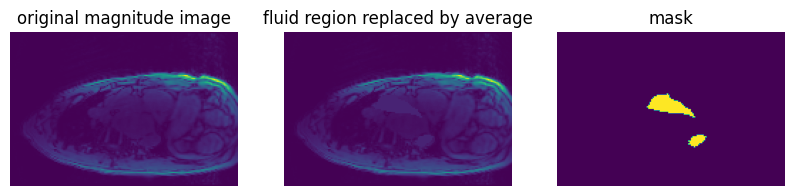

In [33]:

#Question how big is surrounding tissue instenity? 
#Question: shoudl I just adapt this for the masks in the Left ventricle?

# load data
mask_LV_v = in_vivo['mask'][frame].copy()
mask_s = in_silico['mask'][frame].copy()
mag_u_invivo = in_vivo['mag_u'][frame].copy()

idx_slice = np.index_exp[20, :, :]
idx_slice_v = np.index_exp[25, :, :]

# Step 1: fill 
surrsounding_tissue_size = 20

#get average by getting tissue values in bounding box
rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(mask_LV_v)
idx_bounding_box = np.index_exp[rmin-surrsounding_tissue_size:rmax+surrsounding_tissue_size, 
                                cmin-surrsounding_tissue_size:cmax+surrsounding_tissue_size, 
                                zmin-surrsounding_tissue_size:zmax+surrsounding_tissue_size]
bounding_box_mag_u = mag_u_invivo[idx_bounding_box]
bounding_box_mask = mask_LV_v[idx_bounding_box ]
avg_surrounding_tissue = np.average(bounding_box_mag_u[np.where(bounding_box_mask==0)])
print('avg surrounding tissue: ', avg_surrounding_tissue)

# Step 2: Get original intensity values 
avg_fluid_region_invivo = np.average(mag_u_invivo[np.where(mask_LV_v == 1)])
std_fluid_region_invivo = np.std(mag_u_invivo[np.where(mask_LV_v == 1 )])


#Step 1.1 replace masked invivo region with average of surrounding tissue
mag_u_invivo[np.where(mask_LV_v > 0)] = avg_surrounding_tissue

# ----------plot step 1 and 2-------------------
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(in_vivo['mag_u'][frame][idx_slice_v])
plt.title('original magnitude image')
plt.axis('off') 

plt.subplot(1, 3, 2)
plt.imshow(mag_u_invivo[idx_slice_v])
plt.title('fluid region replaced by average')
plt.axis('off') 

plt.subplot(1, 3, 3)
plt.imshow(in_vivo['mask'][frame][idx_slice_v])
plt.title('mask')
plt.axis('off') 

(-0.5, 95.5, 59.5, -0.5)

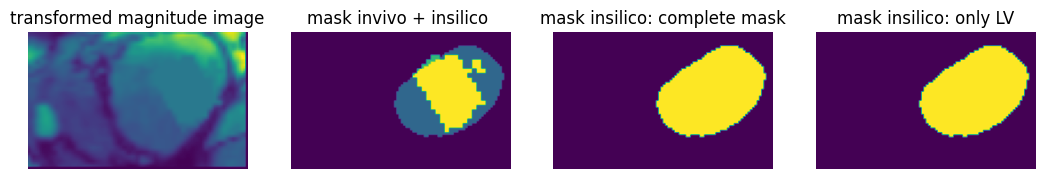

In [34]:
# Step 3 : find transformation and crop invivo to insilico


# new magnitude
temp = indivial_transformation_scale_rotate(mag_u_invivo, scale = [2, 2,2 ], interpolation='linear')
mag_u_transformed = np.zeros_like(in_silico['mag_u'][frame])
mag_u_transformed[idx_insilico] = temp[idx_invivo]

# ----------plot step 3-------------------
plt.figure(figsize=(13, 13))
plt.subplot(1, 4, 1)
plt.imshow(mag_u_transformed[idx_slice])
plt.title('transformed magnitude image')
plt.axis('off') 

plt.subplot(1, 4, 2)
plt.imshow(combined_LV_mask[idx_slice])
plt.title('mask invivo + insilico ')
plt.axis('off') 

plt.subplot(1, 4, 3)
plt.imshow(mask_s[idx_slice])
plt.title('mask insilico: complete mask')
plt.axis('off') 

plt.subplot(1, 4, 4)
plt.imshow(mask_LV_s[idx_slice])
plt.title('mask insilico: only LV')
plt.axis('off') 
#TODO check out combined mask .. something is wrong?? 

In [36]:
# Step 4. 
# mag_u_transformed[np.where(mask_LV_s)]= 0
gauss_kernel = 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])  


# Step 5
print(avg_fluid_region_invivo, std_fluid_region_invivo, avg_surrounding_tissue)
# normal_values = np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape).reshape(50,  -1)
# normal_values_smooth = convolve2d(normal_values, gauss_kernel, mode = 'same')
smoothen = np.ones(mask_s.shape)*avg_fluid_region_invivo
smoothen[np.where(mask_s==1)] = np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape).reshape(mag_u_transformed[np.where(mask_s==1)].shape)
smoothen = scipy.ndimage.gaussian_filter(smoothen, sigma = 0.7)
mag_u_transformed[np.where(mask_s==1)] = smoothen[np.where(mask_s==1)]

# mag_u_transformed[np.where(mask_s)] = normal_values_smooth.reshape(mag_u_transformed[np.where(mask_s)].shape)#np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape)
mag_u_transformed_normal = mag_u_transformed.copy()
mag_u_transformed_normal[np.where(mask_s)] = np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape)
#avg_fluid_region_invivo#
# ----------plot step 1 and 2-------------------
@widgets.interact(x=(0, in_silico['u'].shape[1]-1))
def f_magr(x=10 ):
    idx_slice = np.index_exp[x, :, :]
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(mag_u_transformed[idx_slice])
    plt.title('mag. with normal distr. values smoothed')
    plt.axis('off') 

    img_smooth = convolve2d(mag_u_transformed[idx_slice], gauss_kernel, mode = 'same')
    plt.subplot(1, 3, 2)
    plt.imshow(mag_u_transformed_normal[idx_slice])
    plt.title('mag. with normal distr.')
    plt.axis('off') 

    plt.subplot(1, 3, 3)
    plt.imshow(combined_LV_mask[idx_slice], vmin = 0, vmax = 3)
    plt.title('mask combined')
    plt.axis('off') 

24.96668 7.8733945 39.01921


interactive(children=(IntSlider(value=10, description='x', max=83), Output()), _dom_classes=('widget-interact'…

In [ ]:
def combine_mag_images(mask_v, mask_s, mag_u_invivo ,idx_insilico, idx_invivo):
    
    # Step 1: fill 
    surrsounding_tissue_size = 20

    #get average by getting tissue values in bounding box
    rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(mask_v)
    idx_bounding_box = np.index_exp[rmin-surrsounding_tissue_size:rmax+surrsounding_tissue_size, 
                                    cmin-surrsounding_tissue_size:cmax+surrsounding_tissue_size, 
                                    zmin-surrsounding_tissue_size:zmax+surrsounding_tissue_size]
    bounding_box_mag_u = mag_u_invivo[idx_bounding_box]
    bounding_box_mask = mask_v[idx_bounding_box]
    avg_surrounding_tissue = np.average(bounding_box_mag_u[np.where(bounding_box_mask==0)])

    # Step 2: Get original intensity values 
    avg_fluid_region_invivo = np.average(mag_u_invivo[np.where(mask_v == 1)])
    std_fluid_region_invivo = np.std(mag_u_invivo[np.where(mask_v == 1 )])

    #Step 1.1 replace masked invivo region with average of surrounding tissue
    mag_u_invivo[np.where(mask_v > 0)] = avg_surrounding_tissue

    # Step 3
    # transformation of magnitude
    temp = indivial_transformation_scale_rotate(mag_u_invivo, scale = [2,2,2], interpolation='linear')
    mag_u_transformed = np.zeros_like(mask_s)
    mag_u_transformed[idx_insilico] = temp[idx_invivo]
    
    # transformation of mask
    mask_v_transformed = np.zeros_like(mask_s) 
    mask_v_transformed[idx_insilico] =  indivial_transformation_scale_rotate(mask_v, scale = [2,2,2], interpolation='NN')[idx_invivo]
    combined_mask = mask_v_transformed.copy()
    combined_mask += mask_s*2
    
    # Step 5
    # print(avg_fluid_region_invivo, std_fluid_region_invivo, avg_surrounding_tissue)

    # fill vales from insilico mask with normal ditributed values with same standard deviation as original. Then smoothen the result with gaussian filter
    smoothen = np.ones(mask_s.shape)*avg_fluid_region_invivo
    smoothen[np.where(mask_s==1)] = np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape).reshape(mag_u_transformed[np.where(mask_s==1)].shape)
    smoothen = scipy.ndimage.gaussian_filter(smoothen, sigma = 0.7)

    mag_u_transformed[np.where(mask_s==1)] = smoothen[np.where(mask_s==1)]

    return mag_u_transformed[idx_insilico], combined_mask[idx_insilico] # return values cropped on the in silico data


def transform_magnitude( mask_s,mag_u_invivo, idx_insilico, idx_invivo):
    temp = indivial_transformation_scale_rotate(mag_u_invivo, scale = [2,2,2], interpolation='linear')
    mag_u_transformed = np.zeros_like(mask_s)
    mag_u_transformed[idx_insilico] = temp[idx_invivo]
    return mag_u_transformed[idx_insilico]

In [ ]:
N_frames = in_silico['mask'].shape[0]
mask_v = in_vivo['mask'].copy()
mask_s = in_silico['mask'].copy()

new_shape = mask_s[idx_t_insilico].shape

# new_shape = N_frames, new_shape[0], new_shape[1], new_shape[2]
if new_shape != mask_s.shape:
    print('new data gets cropped from', mask_s.shape, ' to ', new_shape)

mag_u_transformed= np.zeros(new_shape)
mag_v_transformed= np.zeros(new_shape)
mag_w_transformed= np.zeros(new_shape)

# save this into h5 file

save_adapted_magnitude  = '../data/CARDIAC/M1_2mm_step2_invivoP01_magnitude_adapted.h5' # adapted magnitude: insert mask from insilico and do the whole process
save_transformed_magnitude = '../data/CARDIAC/M1_2mm_step2_invivoP01_magnitude.h5'      # only take the cropped and transformed magnitude and dont consider insilico mask

#-------------save magnitude with inserted insilico mask------------------
assert(not os.path.isfile(save_adapted_magnitude)) #file already exists
print('Save new magnitude images including insilico mask in ', save_adapted_magnitude, '..')

for t in range(in_vivo['mag_u'].shape[0]):
    mag_u_transformed[t, :, :, :], _ =              combine_mag_images(mask_v[t], mask_s[t], in_vivo['mag_u'][t],  idx_insilico, idx_invivo)
    mag_v_transformed[t, :, :, :], _ =              combine_mag_images(mask_v[t], mask_s[t], in_vivo['mag_v'][t],  idx_insilico, idx_invivo)
    mag_w_transformed[t, :, :, :], combined_mask =  combine_mag_images(mask_v[t], mask_s[t], in_vivo['mag_w'][t],  idx_insilico, idx_invivo)

# save new magnitude images
prediction_utils.save_to_h5(save_adapted_magnitude, 'mag_u' , mag_u_transformed, compression='gzip')
prediction_utils.save_to_h5(save_adapted_magnitude, 'mag_v' , mag_v_transformed, compression='gzip')
prediction_utils.save_to_h5(save_adapted_magnitude, 'mag_w' , mag_w_transformed, compression='gzip')

with h5py.File(in_silico_path, mode = 'r' ) as p1:
    for vel in vel_colnames:
        prediction_utils.save_to_h5(save_adapted_magnitude, vel , np.array(p1[vel]).squeeze()[idx_t_insilico], compression='gzip')
    for venc in venc_colnames:
        prediction_utils.save_to_h5(save_adapted_magnitude, venc , np.array(p1[venc]).squeeze(), compression='gzip')

    prediction_utils.save_to_h5(save_adapted_magnitude, 'mask' , np.array(p1['mask'])[idx_t_insilico], compression='gzip')
    prediction_utils.save_to_h5(save_adapted_magnitude, 'dx' , np.array(p1['dx']), compression='gzip')

#-------------save magnitude only transformed to insilico shape------------------
assert(not os.path.isfile(save_transformed_magnitude)) #file already exists
print('Save new magnitude images without insilico mask in ', save_transformed_magnitude, '..')

mag_u_transformed= np.zeros(new_shape)
mag_v_transformed= np.zeros(new_shape)
mag_w_transformed= np.zeros(new_shape)

for t in range(in_vivo['mag_u'].shape[0]):
    mag_u_transformed[t, :, :, :] = transform_magnitude(mask_s[t], in_vivo['mag_u'][t], idx_insilico, idx_invivo)
    mag_v_transformed[t, :, :, :] = transform_magnitude(mask_s[t], in_vivo['mag_v'][t], idx_insilico, idx_invivo)
    mag_w_transformed[t, :, :, :] = transform_magnitude(mask_s[t], in_vivo['mag_w'][t], idx_insilico, idx_invivo)

# save transformed magnitude images
prediction_utils.save_to_h5(save_transformed_magnitude, 'mag_u' , mag_u_transformed, compression='gzip')
prediction_utils.save_to_h5(save_transformed_magnitude, 'mag_v' , mag_v_transformed, compression='gzip')
prediction_utils.save_to_h5(save_transformed_magnitude, 'mag_w' , mag_w_transformed, compression='gzip')

with h5py.File(in_silico_path, mode = 'r' ) as p1:
    for vel in vel_colnames:
        prediction_utils.save_to_h5(save_transformed_magnitude, vel , np.array(p1[vel]).squeeze()[idx_t_insilico], compression='gzip')
    for venc in venc_colnames:
        prediction_utils.save_to_h5(save_transformed_magnitude, venc , np.array(p1[venc]).squeeze(), compression='gzip')

    prediction_utils.save_to_h5(save_transformed_magnitude, 'mask' , np.array(p1['mask'][idx_t_insilico]), compression='gzip')
    prediction_utils.save_to_h5(save_transformed_magnitude, 'dx' , np.array(p1['dx']), compression='gzip')


In [ ]:
@widgets.interact(y=(0, in_silico['u'].shape[2]-1))
def f_magr(y=10 ):
    idx_slice = np.index_exp[15, :, y, :]
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(mag_u_transformed[idx_slice])
    plt.title('mag. with normal distr. values smoothed')
    plt.axis('off') 

    # plt.subplot(1, 2, 2)
    # plt.imshow(combined_mask[idx_slice], vmin = 0, vmax = 3)
    # plt.title('mask combined')
    # plt.axis('off') 